# HiSup - Inference large GeoTiff image and return prediction mask in GeoTiff and extracted buildings in Shapefile

This work is based on https://github.com/SarahwXU/HiSup.<br> 
I added several blocks to enable creating prediction results with spatial information.Feel free to reuse it for your own application.<br>
Here you can use fine-tuned model from your own dataset.<br>
To run this Jupyter notebook, you need to preinstall the required packages as instructed by HiSup GitHub.<br>
Change the path for your own application.

In [ ]:
# Define the path
%matplotlib inline

import os
import pathlib

path = os.getcwd()
print(path)

import sys
import numpy as np
sys.path.append(os.path.abspath('.'))

from scripts.demo import inference_no_patching, inference_with_patching
from hisup.config import cfg
from hisup.detector import get_pretrained_model
from skimage import io
import matplotlib.pyplot as plt
import glob

### Inference Functions from HiSup

In [3]:
import torch
import argparse
import numpy as np

from skimage import io
from hisup.config import cfg
from hisup.detector import get_pretrained_model
from hisup.dataset.build import build_transform
from hisup.utils.comm import to_single_device
from hisup.utils.visualizer import show_polygons

import scipy.ndimage
from tqdm import tqdm
from shapely.geometry import Polygon
from skimage.measure import label, regionprops
from hisup.utils.polygon import generate_polygon, juncs_in_bbox
from hisup.utils.visualizer import viz_inria

from hisup.config import cfg
from hisup.detector import BuildingDetector
from hisup.dataset import build_train_dataset
from hisup.utils.comm import to_single_device
from hisup.solver import make_lr_scheduler, make_optimizer
from hisup.utils.logger import setup_logger
from hisup.utils.miscellaneous import save_config
from hisup.utils.metric_logger import MetricLogger
from hisup.utils.checkpoint import DetectronCheckpointer

def inference_single(cfg, model, image, device):
    
    transform = build_transform(cfg)
    
    h_stride, w_stride = 400, 400
    h_crop, w_crop = cfg.DATASETS.ORIGIN.HEIGHT, cfg.DATASETS.ORIGIN.WIDTH
    h_img, w_img, _ = image.shape
    h_grids = max(h_img - h_crop + h_stride - 1, 0) // h_stride + 1
    w_grids = max(w_img - w_crop + w_stride - 1, 0) // w_stride + 1
    pred_whole_img = np.zeros([h_img, w_img], dtype=np.float32)
    count_mat = np.zeros([h_img, w_img])
    juncs_whole_img = []
    
    patch_weight = np.ones((h_crop + 2, w_crop + 2))
    patch_weight[0,:] = 0
    patch_weight[-1,:] = 0
    patch_weight[:,0] = 0
    patch_weight[:,-1] = 0
    
    patch_weight = scipy.ndimage.distance_transform_edt(patch_weight)
    patch_weight = patch_weight[1:-1,1:-1]

    for h_idx in tqdm(range(h_grids), desc='processing on image'):
        for w_idx in range(w_grids):
            y1 = h_idx * h_stride
            x1 = w_idx * w_stride
            y2 = min(y1 + h_crop, h_img)
            x2 = min(x1 + w_crop, w_img)
            y1 = max(y2 - h_crop, 0)
            x1 = max(x2 - w_crop, 0)
            
            crop_img = image[y1:y2, x1:x2, :]
            crop_img_tensor = transform(crop_img.astype(float))[None].to(device)
            
            meta = {
                'height': crop_img.shape[0],
                'width': crop_img.shape[1],
                'pos': [x1, y1, x2, y2]
            }

            with torch.no_grad():
                output, _ = model(crop_img_tensor, [meta])
                output = to_single_device(output, 'cpu')

            juncs_pred = output['juncs_pred'][0]
            mask_pred = output['mask_pred'][0]
            juncs_pred += [x1, y1]
            juncs_whole_img.extend(juncs_pred.tolist())
            mask_pred *= patch_weight
            pred_whole_img += np.pad(mask_pred,
                                ((int(y1), int(pred_whole_img.shape[0] - y2)),
                                (int(x1), int(pred_whole_img.shape[1] - x2))))
            count_mat[y1:y2, x1:x2] += patch_weight

    juncs_whole_img = np.array(juncs_whole_img)
    pred_whole_img = pred_whole_img / count_mat

    return juncs_whole_img, pred_whole_img


def inference_in_batches(cfg, model, image_patches, device):

    for i in range(image_patches.shape[0]):
        
        image = image_patches[i]
        juncs_whole_img_single, pred_whole_img_single = inference_single(cfg, model, image, device)
        juncs_whole_img_single_ex = np.expand_dims(juncs_whole_img_single, axis=0)
        pred_whole_img_single_ex = np.expand_dims(pred_whole_img_single, axis=0)

        if i == 0:
            juncs_whole_img_all = juncs_whole_img_single_ex
            pred_whole_img_all = pred_whole_img_single_ex

        else:
            juncs_whole_img_all = np.concatenate((juncs_whole_img_all, juncs_whole_img_single_ex), axis=0)
            pred_whole_img_all = np.concatenate((pred_whole_img_all, pred_whole_img_single_ex), axis=0)

    return juncs_whole_img_all, pred_whole_img_all


def convert_mask_to_polygons(juncs_whole_img, pred_whole_img):
    # match junction and seg results
    polygons = []
    props = regionprops(label(pred_whole_img > 0.5))
    for prop in tqdm(props, leave=False, desc='polygon generation'):
        y1, x1, y2, x2 = prop.bbox
        bbox = [x1, y1, x2, y2]
        select_juncs = juncs_in_bbox(bbox, juncs_whole_img, expand=8)
        poly, juncs_sa, _, _, juncs_index = generate_polygon(prop, pred_whole_img, \
                                                                    select_juncs, pid=0, test_inria=True)
        if juncs_sa.shape[0] == 0:
            continue
        
        if len(juncs_index) == 1:
            polygons.append(Polygon(poly))
        else:
            poly_ = Polygon(poly[juncs_index[0]], \
                            [poly[idx] for idx in juncs_index[1:]])
            polygons.append(poly_)
    
    return polygons

def get_pretrained_model_FT(cfg, dataset, device, path_model, pretrained=True):
    
    model = BuildingDetector(cfg, test=True)
    # if pretrained:
    #     url = PRETRAINED[dataset]
    #     state_dict = torch.hub.load_state_dict_from_url(url, map_location=device, progress=True)
    # state_dict = {k[7:]:v for k,v in state_dict['model'].items() if k[0:7] == 'module.'}
    # model.load_state_dict(state_dict)
    # state_dict = model.load_state_dict(path_model)
    # state_dict = {k[7:]:v for k,v in state_dict['model'].items() if k[0:7] == 'module.'}
    # model.load_state_dict(state_dict)
    state_dict = torch.load(path_model)
    model.load_state_dict(state_dict["model"])
    model = model.eval()

    return model

### Load data

In [3]:
path_data = os.path.join(path, "data")
path_test = os.path.join(path_data, "outputs")
img_path = "path to your geotif file"

### Crop a geotiff raster whose width and height can be divided by 512 (may be optional), and save it as a new geotiff raster

In [18]:
import rasterio
from rasterio.windows import Window
from patchify import patchify, unpatchify

src = rasterio.open(img_path)
width = src.width
height = src.height

patchsize = 512
width_new = int(width / patchsize) * patchsize
height_new = int(height / patchsize) * patchsize
print(width, height, width_new, height_new)

xmin, xmax = 0, width_new
ymin, ymax = 0, height_new
xoff, yoff = 1, 1

# Create a Window and calculate the transform from the source dataset    
window = Window(xoff, yoff, width_new, height_new)
transform = src.window_transform(window)

profile = src.profile
print(profile)
profile.update({
    'height': height_new, # it can be confusing
    'width': width_new,
    'transform': transform})
print(profile)

img_out_path = os.path.join(path_test, "image_test_cropped.tif")
with rasterio.open(img_out_path, 'w', **profile) as dst:
    # Read the data from the window and write it to the output raster
    dst.write(src.read(window=window))

4680 4316 4608 4096
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 4680, 'height': 4316, 'count': 3, 'crs': CRS.from_epsg(32646), 'transform': Affine(0.125, 0.0, 411237.08788609505,
       0.0, -0.125, 2343242.105707079), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 4608, 'height': 4096, 'count': 3, 'crs': CRS.from_epsg(32646), 'transform': Affine(0.125, 0.0, 411237.21288609505,
       0.0, -0.125, 2343241.980707079), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


### Load pretrained model from your data or Infria or Crowdai data

In [19]:
import torch

dataset = 'crowdai' # crowdai inria
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

img_path = os.path.join(path_test, "image_test_cropped.tif")
image = io.imread(img_path)[:, :, :3]

H, W = patchsize, patchsize # patchsize = 512
cfg.DATASETS.ORIGIN.HEIGHT = 512 if H > 512 else H
cfg.DATASETS.ORIGIN.WIDTH = 512 if W > 512 else W

# here I 
# load your pretrained model
path_model = "path to pretrained model(.pth)"

model = get_pretrained_model_FT(cfg, dataset, device, path_model, pretrained=True)
model = model.to(device)

/home/yunya/anaconda3/envs/hisup/HiSup/outputs/crowdai_hrnet48_Kutupalong2018/model_00010.pth
INFO:build hrnet-w48-v2 backbone


### Inference, creating mask raster

In [20]:
import scipy.ndimage
from tqdm import tqdm
from shapely.geometry import Polygon
from skimage.measure import label, regionprops
from hisup.utils.polygon import generate_polygon, juncs_in_bbox
from hisup.utils.visualizer import viz_inria

transform = build_transform(cfg)

h_stride, w_stride = 400, 400
h_crop, w_crop = cfg.DATASETS.ORIGIN.HEIGHT, cfg.DATASETS.ORIGIN.WIDTH
h_img, w_img, _ = image.shape
h_grids = max(h_img - h_crop + h_stride - 1, 0) // h_stride + 1
w_grids = max(w_img - w_crop + w_stride - 1, 0) // w_stride + 1
pred_whole_img = np.zeros([h_img, w_img], dtype=np.float32)
count_mat = np.zeros([h_img, w_img])
juncs_whole_img = []

patch_weight = np.ones((h_crop + 2, w_crop + 2))
patch_weight[0,:] = 0
patch_weight[-1,:] = 0
patch_weight[:,0] = 0
patch_weight[:,-1] = 0

patch_weight = scipy.ndimage.distance_transform_edt(patch_weight)
patch_weight = patch_weight[1:-1,1:-1]

In [21]:
for h_idx in tqdm(range(h_grids), desc='processing on image'):
    for w_idx in range(w_grids):
        y1 = h_idx * h_stride
        x1 = w_idx * w_stride
        y2 = min(y1 + h_crop, h_img)
        x2 = min(x1 + w_crop, w_img)
        y1 = max(y2 - h_crop, 0)
        x1 = max(x2 - w_crop, 0)

        crop_img = image[y1:y2, x1:x2, :]
        crop_img_tensor = transform(crop_img.astype(float))[None].to(device)

        meta = {
            'height': crop_img.shape[0],
            'width': crop_img.shape[1],
            'pos': [x1, y1, x2, y2]
        }

        with torch.no_grad():
            output, _ = model(crop_img_tensor, [meta])
            output = to_single_device(output, 'cpu')

        juncs_pred = output['juncs_pred'][0]
        mask_pred = output['mask_pred'][0]
        juncs_pred += [x1, y1]
        juncs_whole_img.extend(juncs_pred.tolist())
        mask_pred *= patch_weight
        pred_whole_img += np.pad(mask_pred,
                            ((int(y1), int(pred_whole_img.shape[0] - y2)),
                            (int(x1), int(pred_whole_img.shape[1] - x2))))
        count_mat[y1:y2, x1:x2] += patch_weight

juncs_whole_img = np.array(juncs_whole_img)
pred_whole_img = pred_whole_img / count_mat

processing on image: 100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


### Save predicted masks

In [22]:
# save predicted mask and shapefile with geoinformation

import pathlib
import geopandas as gpd
import rasterio

path_out_img = os.path.join(path_test, "Pred_Mask")
path_out_shp = os.path.join(path_test, "Pred_Shp")

pathlib.Path(path_out_img).mkdir(parents=True, exist_ok=True) 
pathlib.Path(path_out_shp).mkdir(parents=True, exist_ok=True) 

# https://geobgu.xyz/py/rasterio.html
with rasterio.open(img_path) as src:
    ras_meta = src.profile
    crs = src.crs # for vector
    ras_meta["count"] = 1 # for raster
    ras_meta["dtype"] = "float32" 

pred_whole_img_ = np.expand_dims(pred_whole_img[...], axis=0)

path_out_img = "path to output mask (.tif)"
with rasterio.open(path_out_img, 'w', **ras_meta) as dst:
    dst.write(pred_whole_img_)

### Predict polygons

In [23]:
# match junction and seg results
polygons = []
thres = 0.5 # it can be an important variable, 0.5 may not be always the best option.

props = regionprops(label(pred_whole_img > thres))
for prop in tqdm(props, leave=False, desc='polygon generation'):
    y1, x1, y2, x2 = prop.bbox
    bbox = [x1, y1, x2, y2]
    select_juncs = juncs_in_bbox(bbox, juncs_whole_img, expand=8)
    poly, juncs_sa, _, _, juncs_index = generate_polygon(prop, pred_whole_img, select_juncs, pid=0, test_inria=True)
                                                                
    if juncs_sa.shape[0] == 0:
        continue

    if len(juncs_index) == 1:
        polygons.append(Polygon(poly))
    else:
        poly_ = Polygon(poly[juncs_index[0]], \
                        [poly[idx] for idx in juncs_index[1:]])
        polygons.append(poly_)

In [24]:
# add geoinformation to the created polygons

from shapely.affinity import scale
from shapely.ops import transform
from shapely.geometry import Polygon
import rasterio
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries

img_path = os.path.join(path_test, "image_test_cropped.tif")
src = rasterio.open(img_path)
left, bottom = src.bounds.left, src.bounds.bottom
    
# it is important to set the resolution when creating the final polygons in shapefile
resolution = 0.1

for poly in polygons:

    x, y = poly.exterior.coords.xy
    x_ = x.tolist()
    y_ = y.tolist()

    x__ = [i*resolution + left for i in x_]
    y__ = [j*resolution + bottom for j in y_]
    
    poly_geo = Polygon(zip(x__, y__))
    polygons_geo.append(poly_geo)

len(polygons_geo)

1107

### Save polygons

In [25]:
polygons_gpd = gpd.GeoSeries(polygons_geo)

origin = ((src.bounds.left + src.bounds.right)/2, (src.bounds.top + src.bounds.bottom)/2)
flip = GeoSeries.scale(polygons_gpd, xfact=1.0, yfact=-1.0, zfact=0, origin=origin) 

path_shp_out = "output shapefile (.shp)"
gdf = gpd.GeoDataFrame(crs=crs, geometry=flip)
gdf.to_file(os.path.join(path_out_shp, path_shp_out), driver='ESRI Shapefile')

### Visualize polygons

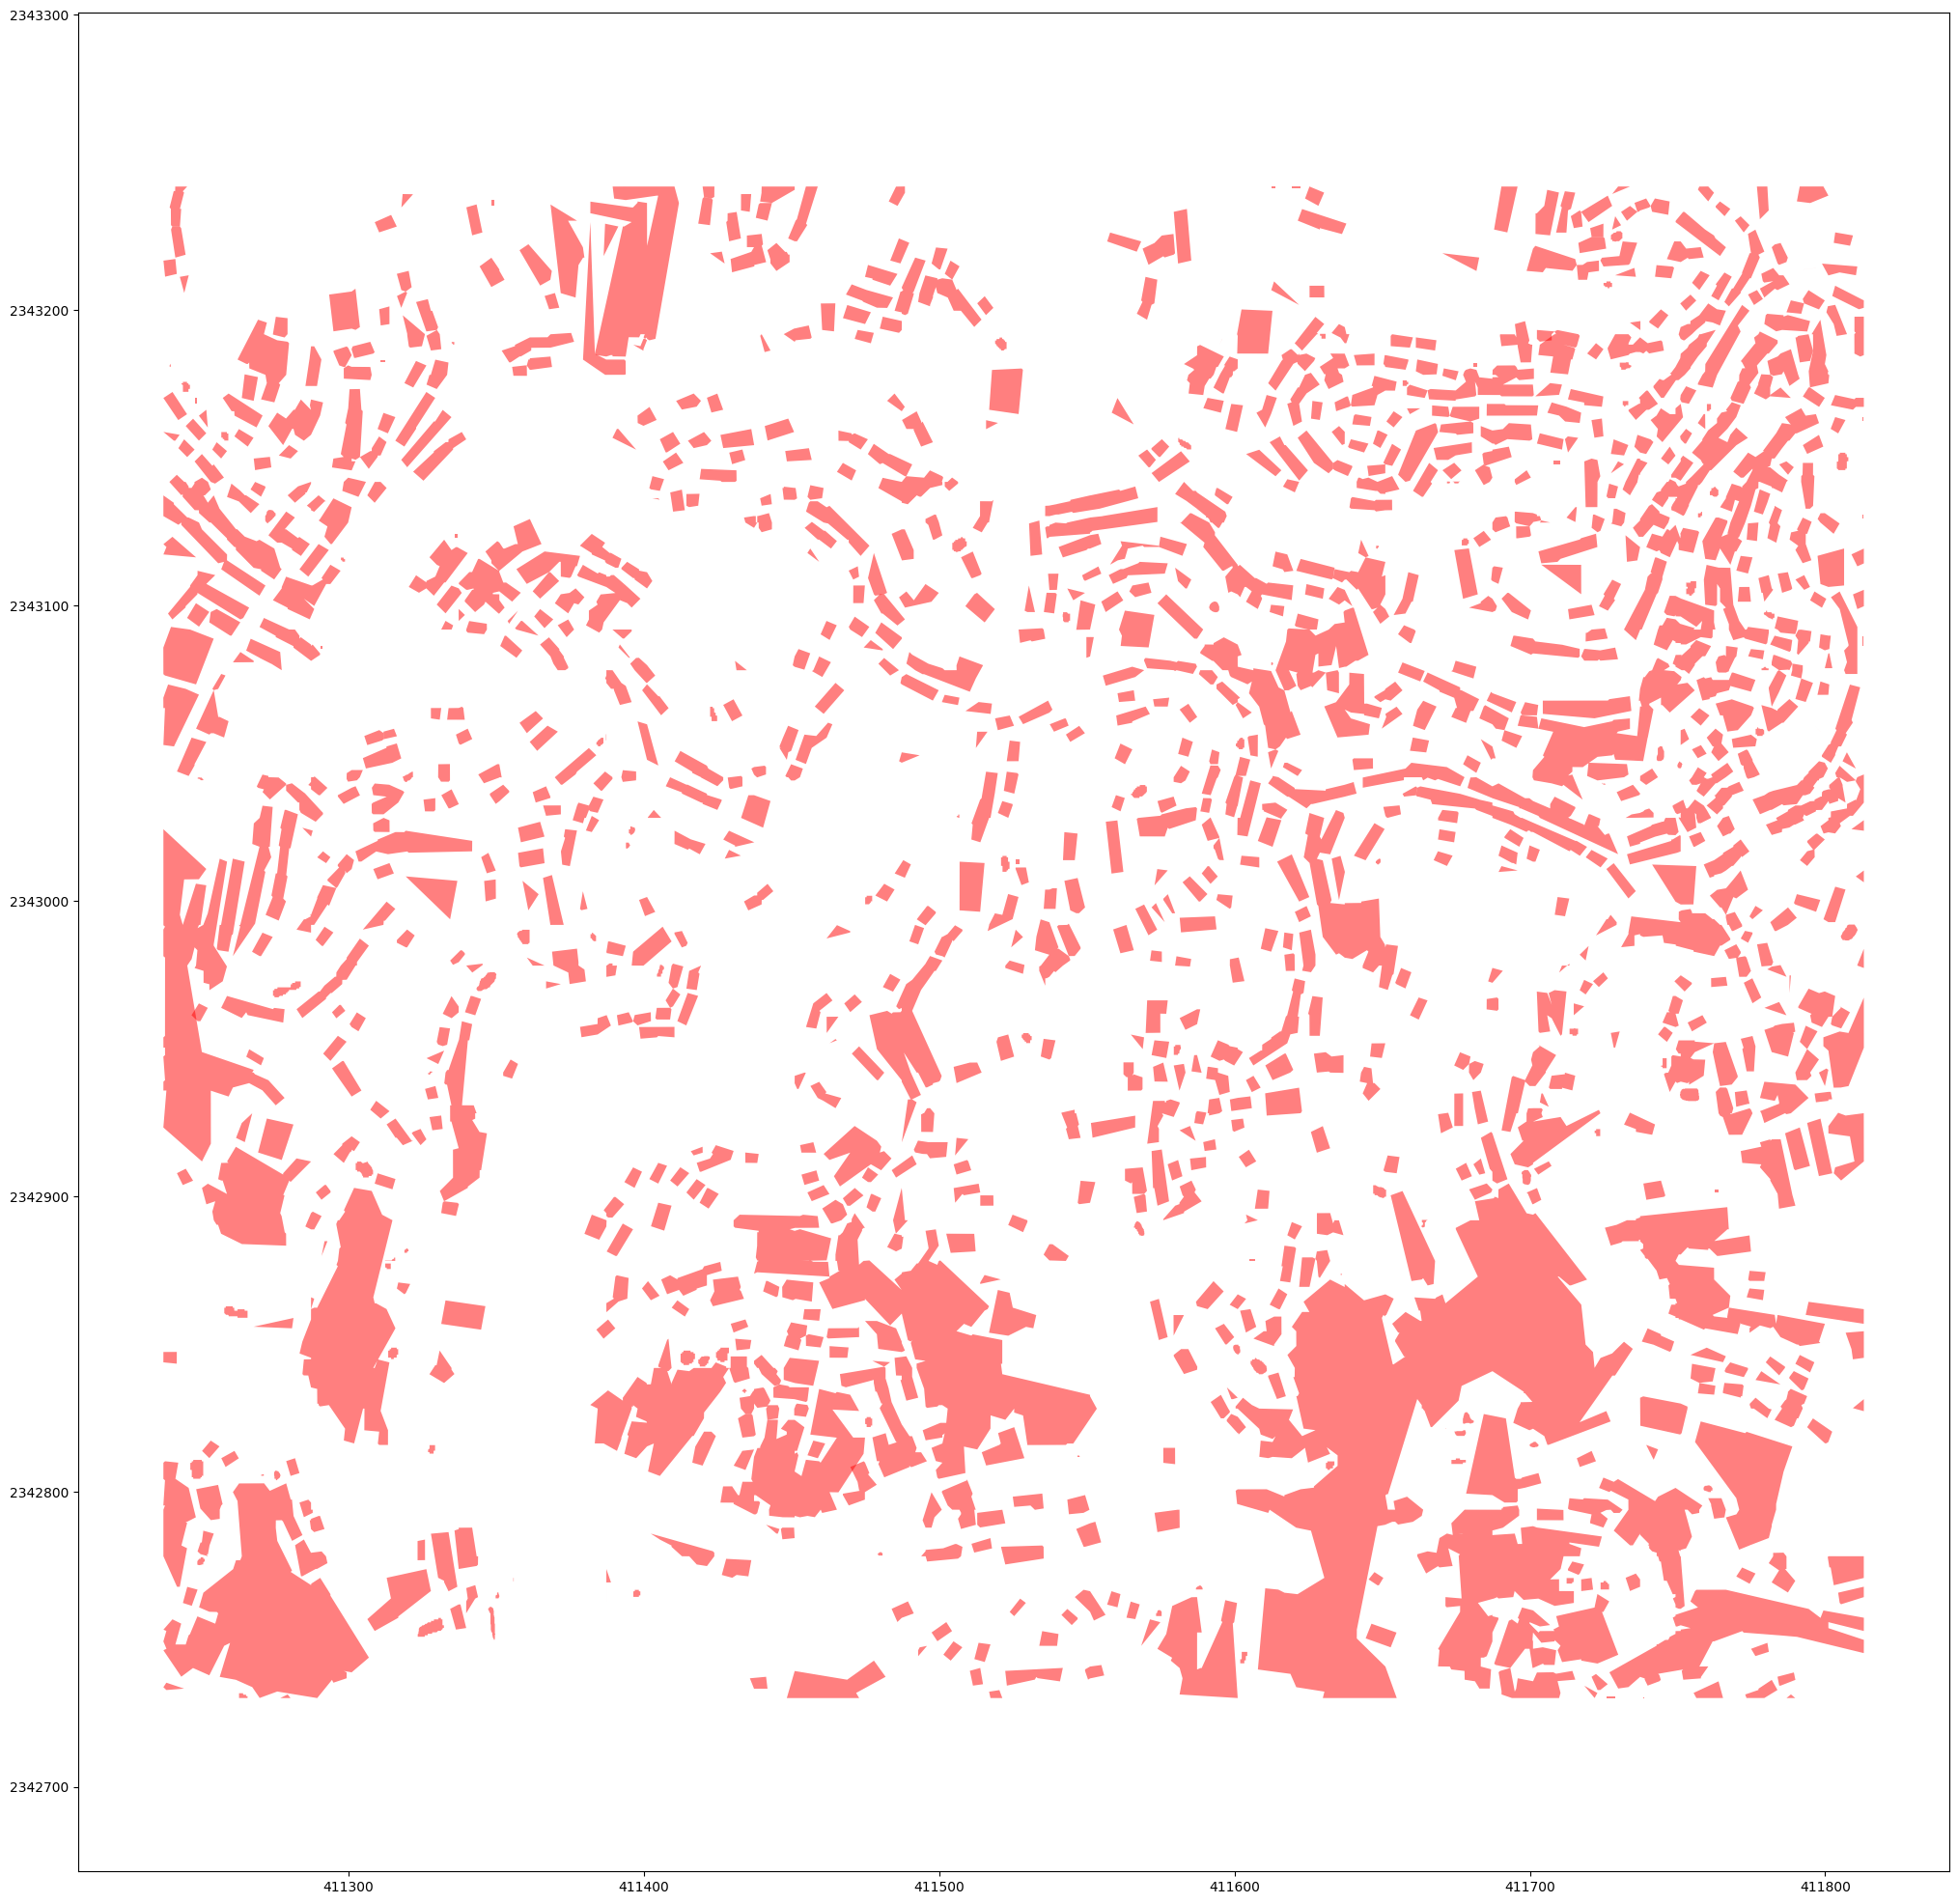

In [26]:
# flip
import matplotlib.pyplot as plt

fig, axs = plt.subplots()
fig.set_size_inches(25, 25)
axs.set_aspect('equal', 'datalim')

for geom in flip:   
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=0.5, fc='r', ec='none')

plt.show()